In [60]:
import sys
import os
import time
import datetime
import argparse
import copy

import numpy as np
import pandas as pd

import torch
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations as albu
import matplotlib.pyplot as plt

from skimage.io import imread, imsave

from utils import get_mask, joint_transform, LARGE_CHIP_SIZE, CHIP_SIZE
from torch.utils.data import IterableDataset, DataLoader

In [10]:
PATH = './data'
TRAIN = 'train_v2/'
TEST = 'test_v2/'
SEGMENTATION = 'train_ship_segmentations_v2.csv'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
              '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
              'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
              'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] 

tr_arr = np.array(pd.read_csv('./data/train_df.csv')['0'].reset_index(drop=True))
val_arr = np.array(pd.read_csv('./data/val_df.csv')['0'].reset_index(drop=True))
test_arr = np.array(pd.read_csv('./data/test_df.csv')['0'].reset_index(drop=True))

for el in exclude_list:
    if(el in tr_arr): tr_arr.remove(el)
    if(el in val_arr): val_arr.remove(el)
    if(el in test_arr): test_arr.remove(el)

segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')

tr_n = tr_arr
val_n = val_arr
test_n = test_arr


# IF CUT_EMPTY
def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n = cut_empty(tr_n)
val_n = cut_empty(val_n)
test_n = cut_empty(test_n)

In [11]:
len(tr_n)

34376

In [61]:
segmentation_df = pd.read_csv('./data/train_ship_segmentations_v2.csv').set_index('ImageId')

In [14]:
tr_n[0] in segmentation_df.index

True

In [62]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

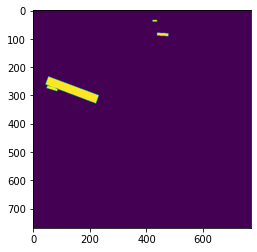

In [19]:
plt.imshow(get_mask(tr_n[0], segmentation_df))

In [63]:
class StreamingShipValTestDataset(IterableDataset):
    
    def __init__(self, fn, data_root_dir, num_patches=8, chip_size=256, large_chip_size=362, 
                 transform=joint_transform, rotation_augmentation=False, only_ships=True, verbose = False):

        tr_n = np.array(pd.read_csv(fn)['0'].reset_index(drop=True))
        
        self.data_root_dir = data_root_dir

        self.segmentation_df = pd.read_csv('./data/train_ship_segmentations_v2.csv').set_index('ImageId')
        
        exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']

        for el in exclude_list:
            if(el in tr_n): tr_n.remove(el)
        
        if only_ships:
            def cut_empty(names):
                return [name for name in names 
                        if(type(self.segmentation_df.loc[name]['EncodedPixels']) != float)]

            tr_n = cut_empty(tr_n)
        
        self.image_fns = tr_n
        
        print(len(tr_n))

        self.num_patches = num_patches
        self.chip_size = chip_size
        self.large_chip_size = large_chip_size
        self.rotation_augmentation = rotation_augmentation
        self.verbose = verbose
                        
        self.transform = transform

    def stream_tile_fns(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None: # In this case we are not loading through a DataLoader with multiple workers
            worker_id = 0
            num_workers = 1
        else:
            worker_id = worker_info.id
            num_workers = worker_info.num_workers

        if self.verbose:
            print("Creating a filename stream for worker %d" % (worker_id))

        # This logic splits up the list of filenames into `num_workers` chunks. Each worker will recieve ceil(num_filenames / num_workers) filenames to generate chips from. If the number of workers doesn't divide the number of filenames evenly then the last worker will have fewer filenames.
        N = len(self.image_fns)
        num_files_per_worker = int(np.ceil(N / num_workers))
        lower_idx = worker_id * num_files_per_worker
        upper_idx = min(N, (worker_id+1) * num_files_per_worker)
        for idx in range(lower_idx, upper_idx):

            img_fn = self.image_fns[idx]

            if self.verbose:
                print("Worker %d, yielding file %d" % (worker_id, idx))

            yield (idx, img_fn)

    def stream_chips(self):
        for (idx, img_fn) in self.stream_tile_fns():
            num_skipped_chips = 0
            
            img_path = os.path.join(self.data_root_dir, img_fn)
            
            # Read images
            img_fp = imread(img_path)
            print(img_path)
            
            # Read masks
            if img_fn in self.segmentation_df.index:
                mask_fp = get_mask(img_fn, self.segmentation_df)
            else:
                mask_fp = np.zeros((768, 768), dtype=np.uint8)
            
            height, width, channel = img_fp.shape
            l_height, l_width = mask_fp.shape

            assert height == l_height and width == l_width
            
            # Randomly sample NUM_PATCHES from image
            
            for i in range(self.num_patches):
                # Select the top left pixel of our chip randomly
                x = np.random.randint(0, width-self.large_chip_size)
                y = np.random.randint(0, height-self.large_chip_size)

                # Read imagery / labels
                p_img = None
                p_mask = None
            
                p_img = img_fp[y:y+self.large_chip_size, x:x+self.large_chip_size, :]
                p_mask = mask_fp[y:y+self.large_chip_size, x:x+self.large_chip_size]

                if self.rotation_augmentation:
                    p_img, p_mask = self.transform(p_img, p_mask, rotation_augmentation=True)
                else:
                    p_img, p_mask = self.transform(p_img, p_mask, rotation_augmentation=False)

                assert p_img.shape == (3,256,256) and p_mask.shape == (256,256)

                yield p_img, p_mask


            if num_skipped_chips>0 and self.verbose:
                print("We skipped %d chips on %s" % (img_fn))

    def __iter__(self):
        if self.verbose:
            print("Creating a new StreamingGeospatialDataset iterator")
        return iter(self.stream_chips())

In [64]:
streaming_dataset = StreamingShipValTestDataset("./data/val_df.csv", "./data/train_v2/", 
                                         large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform,
                                         rotation_augmentation=True, only_ships=False)

loader = DataLoader(dataset=streaming_dataset, batch_size = 1)

8184


./data/train_v2/808f09825.jpg


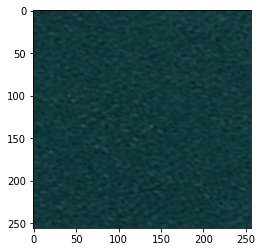

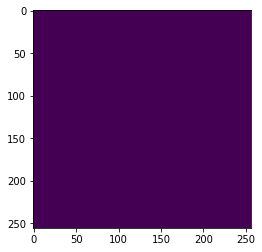

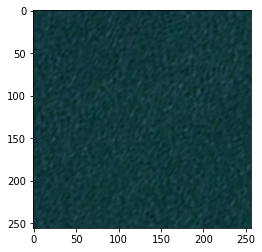

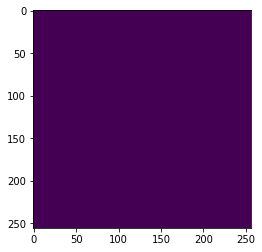

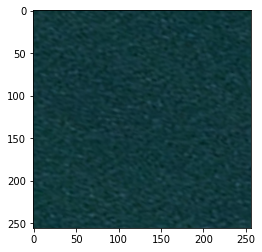

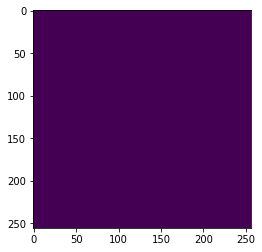

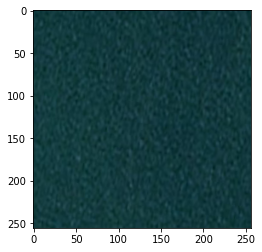

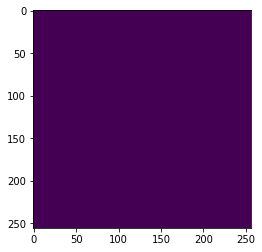

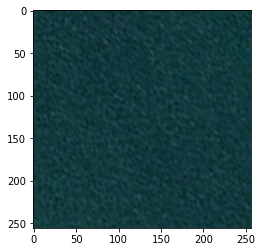

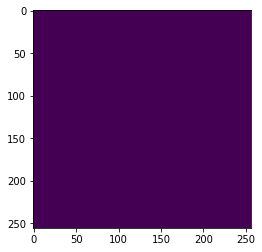

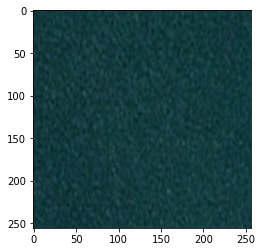

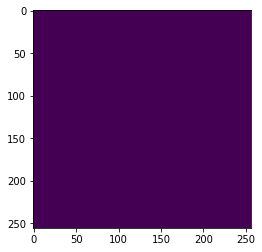

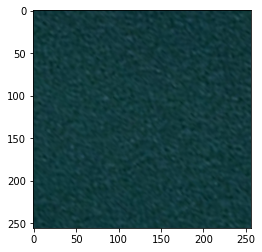

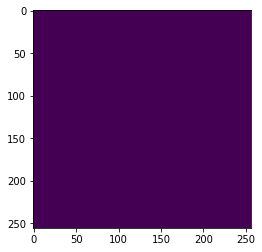

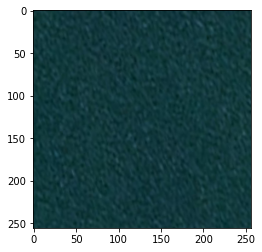

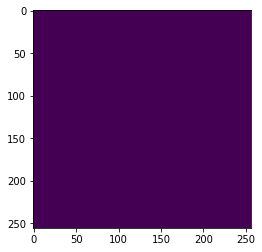

./data/train_v2/dd5ea0001.jpg


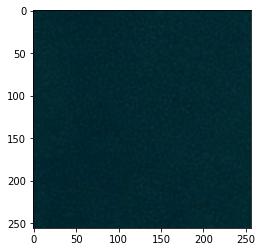

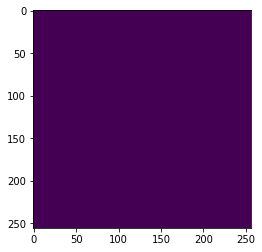

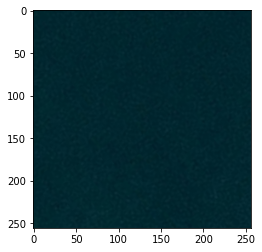

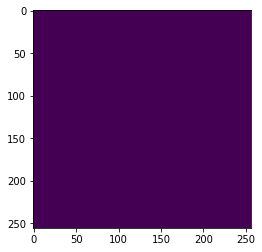

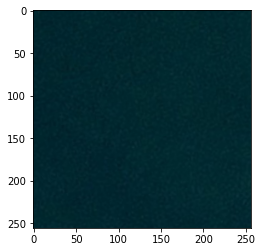

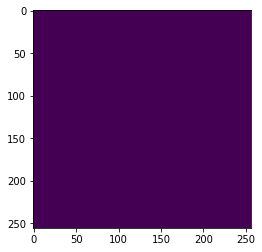

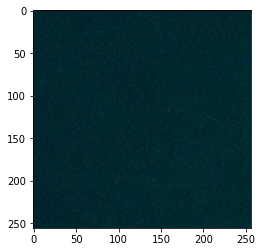

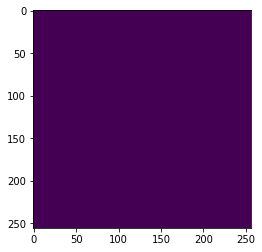

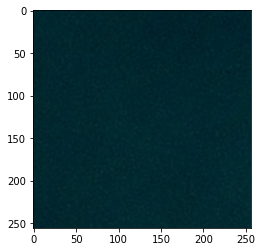

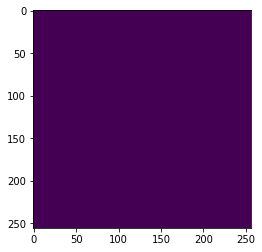

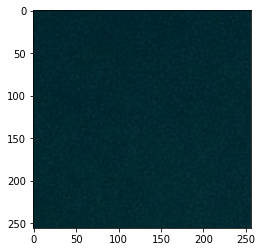

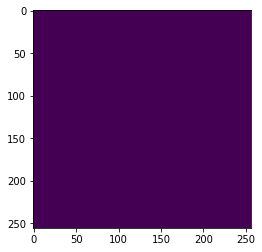

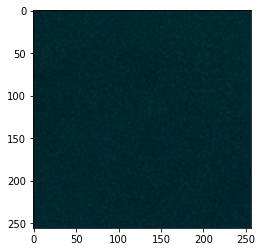

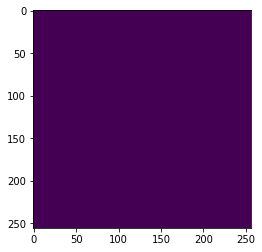

In [69]:
for i, (img,mask) in enumerate(loader):
    if i == 15: break
        
    plt.figure()
    plt.imshow(np.moveaxis(np.array(img[0]),0,-1))
    plt.show()
    plt.close()
    
    plt.figure()
    plt.imshow(mask[0])
    plt.show()
    plt.close()